In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

In [6]:
file_path = os.path.join(os.environ.get('rawdir'),'hre10_nudg','ocean_avg_00??.nc')
grd_path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom10_grd.nc')

avg = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})
grd = xr.open_dataset(grd_path)

<IPython.core.display.Javascript object>


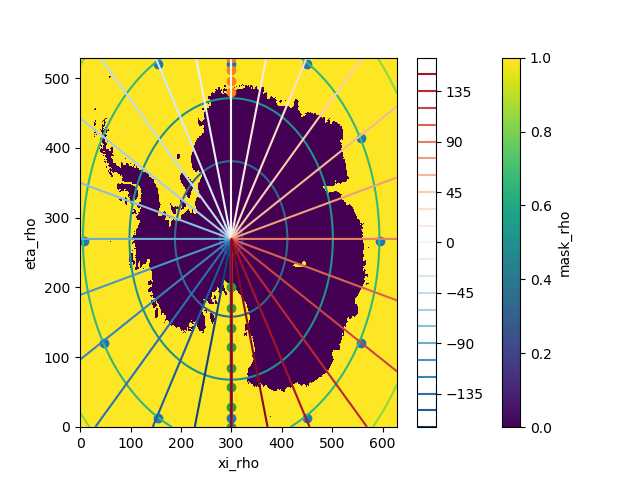

In [5]:
%matplotlib notebook
xi_zonal = [8,47,155,300,450,557,595,557,300,450,155]
eta_zonal = [266,120,12,12,12,120,266,414,520,520,520]
xi_meri_0 = [300,300,300,300]
eta_meri_0 = np.linspace(529,480,4,dtype=int)
xi_meri_180 = np.repeat(300,8)
eta_meri_180 = np.linspace(0,200,8,dtype=int)
plt.close()
grd.mask_rho.plot()
grd.lat_rho.plot.contour()
contour = grd.lon_rho.plot.contour(levels=36)
plt.colorbar(contour)
plt.scatter(xi_zonal,eta_zonal)
plt.scatter(xi_meri_0,eta_meri_0)
plt.scatter(xi_meri_180,eta_meri_180)
plt.show()

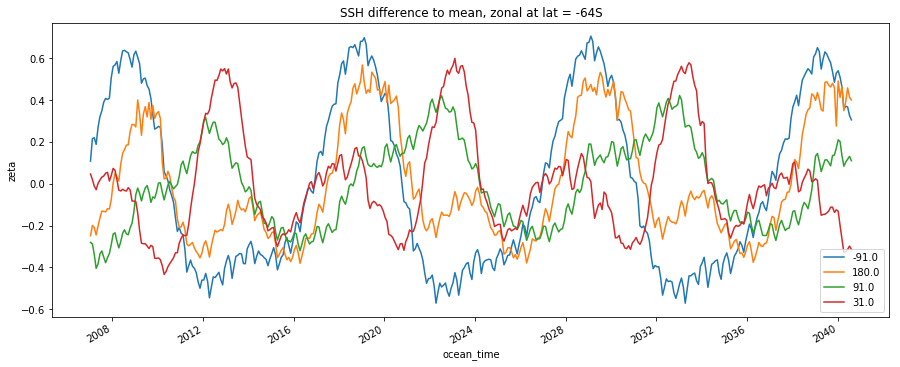

In [25]:
plt.close()
plt.figure(figsize=(15,6))
for e,x in zip(eta_zonal[::3],xi_zonal[::3]):
    label=str(np.round(grd.isel(eta_rho=e,xi_rho=x).lon_rho.values))
    mean = avg.isel(eta_rho=e,xi_rho=x).zeta.mean()
    (avg.isel(eta_rho=e,xi_rho=x).zeta-mean).plot(label=label)
plt.title('SSH difference to mean, zonal at lat = -64S')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


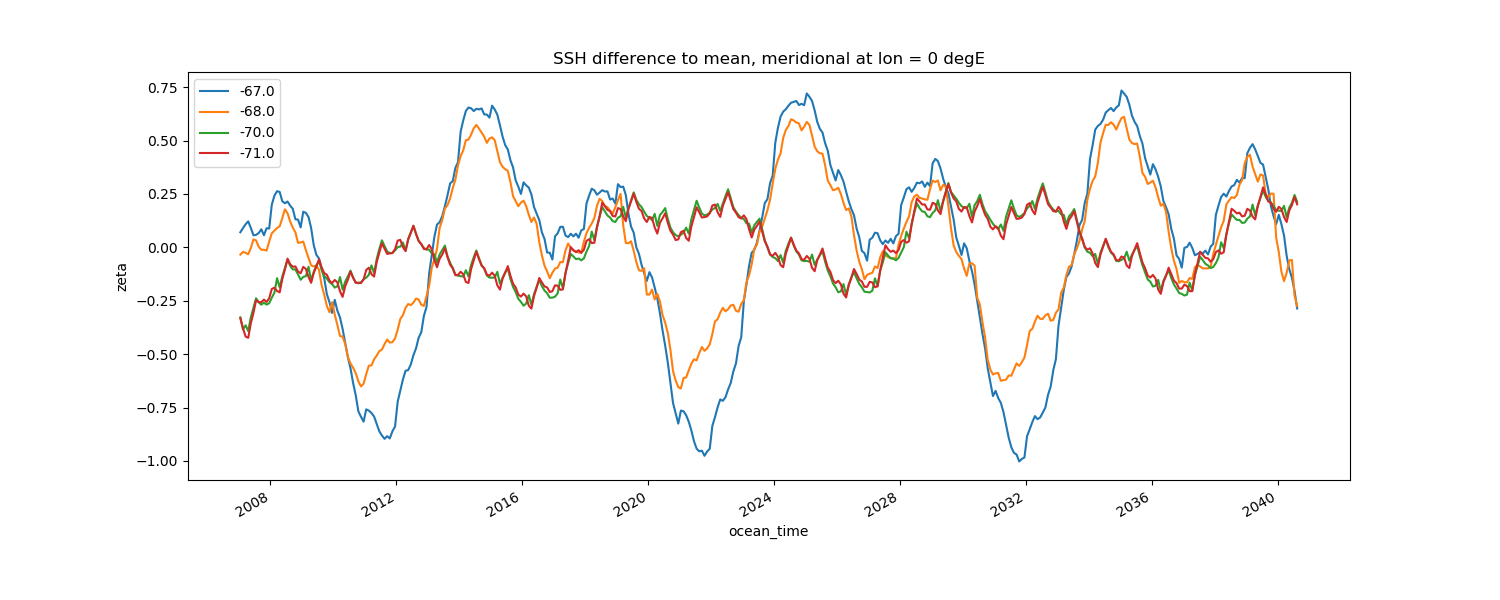

In [8]:
plt.close()
plt.figure(figsize=(15,6))
for e,x in zip(eta_meri_0,xi_meri_0):
    label=str(np.round(grd.isel(eta_rho=e,xi_rho=x).lat_rho.values))
    mean = avg.isel(eta_rho=e,xi_rho=x).zeta.mean()
    (avg.isel(eta_rho=e,xi_rho=x).zeta-mean).plot(label=label)
plt.title('SSH difference to mean, meridional at lon = 0 degE')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


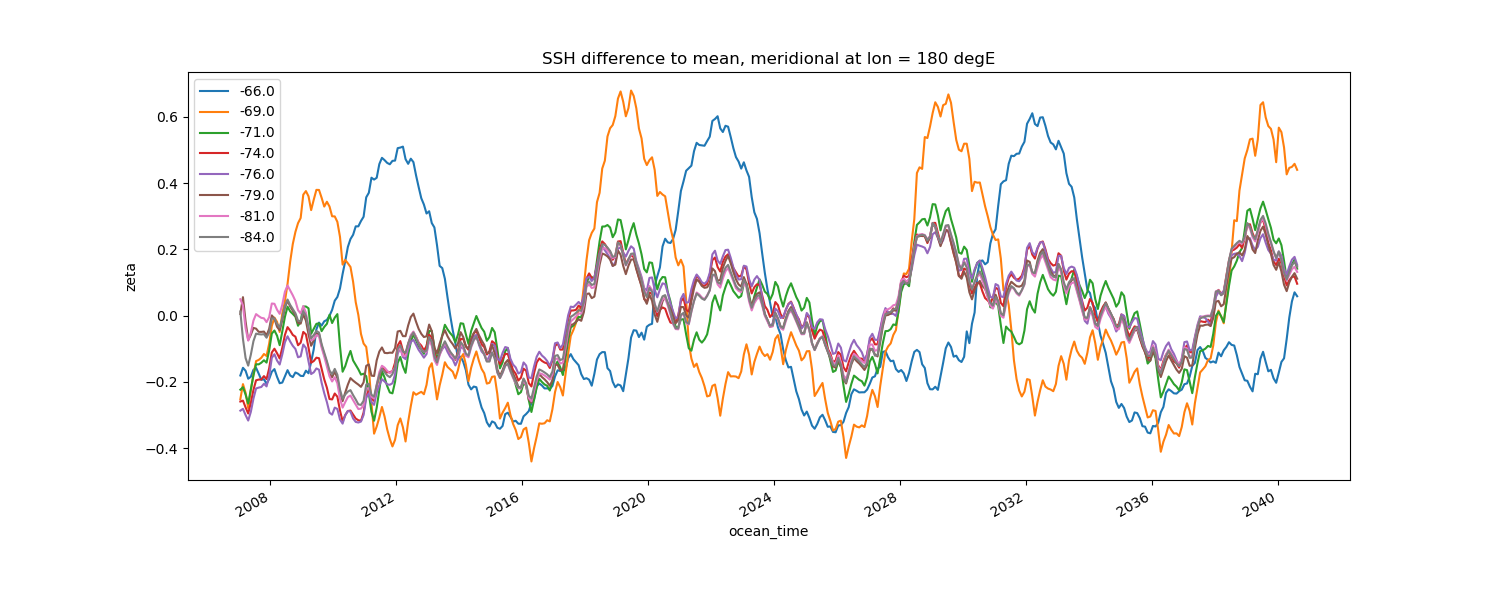

In [7]:
plt.close()
plt.figure(figsize=(15,6))
for e,x in zip(eta_meri_180,xi_meri_180):
    label=str(np.round(grd.isel(eta_rho=e,xi_rho=x).lat_rho.values))
    mean = avg.isel(eta_rho=e,xi_rho=x).zeta.mean()
    (avg.isel(eta_rho=e,xi_rho=x).zeta-mean).plot(label=label)
plt.title('SSH difference to mean, meridional at lon = 180 degE')
plt.legend()
plt.show()

In [42]:
# %load src/visualization/plot_barotropic_xr.py
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo 
import os
import sys
import xarray as xr

from ipywidgets import interact

from features.rotate_vector_roms import rotate_vector_roms
#ds = avgn
   
    
block = 10
def plot_uv(ds):
    
    # Radius of the Earth in metres
    r = 6.371e6
    # Degrees to radians conversion factor
    deg2rad = np.pi/180
    # Side length of blocks to average vectors over (can't plot vector at every
    # single point or the plot will be way too crowded)

    lon = grd.lon_rho.values
    lat = grd.lat_rho.values

    def widget(month):
        
        u = ds.u.sel(ocean_time=month).isel(s_rho=15).values
        v = ds.v.sel(ocean_time=month).isel(s_rho=15).values

        angle = np.zeros(np.shape(lon))
        u_rho,v_rho = rotate_vector_roms(u, v, angle)

        speed = np.sqrt(np.square(u_rho)+np.square(v_rho))

        #print('initialize and fill up the arrays')
        numy = np.size(lon,0) #530
        numx = np.size(lon,1) #630
        x = np.arange(numx)
        y = np.arange(numy)
        xmesh,ymesh = np.meshgrid(x,y)
        #print(numx,numy,x,y)

        # Average x, y, u_circ, and v_circ over block x block intervals
        # Calculate number of blocks
        size0 = int(np.ceil(numy/float(block)))
        size1 = int(np.ceil(numx/float(block)))

        # Set up arrays for averaged fields
        x_block = np.ma.empty([size0, size1])
        y_block = np.ma.empty([size0, size1])
        u_block = np.ma.empty([size0, size1])
        v_block = np.ma.empty([size0, size1])
        # Set up arrays containing boundary indices
        posn0 = list(np.arange(0, numy, block))
        posn0.append(numy)
        posn1 = list(np.arange(0, numx, block))
        posn1.append(numx)
        #print(posn0,posn1)
        # Double loop to average each block (can't find a more efficient way to do
        # this)
        for j in np.arange(size0):
            for i in np.arange(size1):
                start0 = posn0[j]
                end0 = posn0[j+1]
                start1 = posn1[i]
                end1 = posn1[i+1]
                x_block[j,i] = np.mean(xmesh[start0:end0, start1:end1])
                y_block[j,i] = np.mean(ymesh[start0:end0, start1:end1])
                u_block[j,i] = np.mean(u_rho[start0:end0, start1:end1])
                v_block[j,i] = np.mean(v_rho[start0:end0, start1:end1])

        # Make the plot

        fig,(ax0,ax1) = plt.subplots(2,figsize=(15,15))

        speedP = ax0.pcolormesh(xmesh,ymesh,speed*100, vmin=0,vmax=20, cmap=cmo.speed)
        plt.colorbar(speedP,ax=ax0)
        # Add vectors for each block
        quiverP = ax0.quiver(x_block, y_block, u_block, v_block,pivot="mid", color='black')#,scale_units='xy',scale=0.01)
        ax0.set_title('Monthly mean mid water column velocity (cm/s) '+str(month), fontsize=16)
        ax0.set_aspect('equal')
        ax0.axis('off')
        ds.temp.sel(ocean_time=month).isel(s_rho=15).plot(ax=ax1,vmin=-1.5,vmax=7,cmap=cmo.thermal)
        ax1.set_title('mid water column surface temp in degC', fontsize=16)
        ax1.set_aspect('equal')
        ax1.axis('off')
        plt.tight_layout()
        plt.show()
        
    interact(widget,month=ds.ocean_time.values)

In [47]:
file_path=os.path.join(os.environ.get('rawdir'),'waom4','ocean_avg_00??.nc')
avg = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})

grd_path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom4_grd.nc')
grd = xr.open_dataset(grd_path)

plot_uv(avg)

interactive(children=(Dropdown(description='month', options=(numpy.datetime64('2012-01-15T05:00:00.000000000'), numpy.datetime64('2012-02-14T15:00:00.000000000'), numpy.datetime64('2012-03-16T01:00:00.000000000'), numpy.datetime64('2012-04-15T11:00:00.000000000'), numpy.datetime64('2012-05-15T21:00:00.000000000'), numpy.datetime64('2012-06-15T07:00:00.000000000'), numpy.datetime64('2012-07-15T17:00:00.000000000'), numpy.datetime64('2012-08-15T03:00:00.000000000'), numpy.datetime64('2012-09-14T13:00:00.000000000'), numpy.datetime64('2012-10-14T23:00:00.000000000'), numpy.datetime64('2012-11-14T09:00:00.000000000'), numpy.datetime64('2012-12-14T19:00:00.000000000'), numpy.datetime64('2013-01-14T05:00:00.000000000'), numpy.datetime64('2013-02-13T15:00:00.000000000'), numpy.datetime64('2013-03-16T01:00:00.000000000'), numpy.datetime64('2013-04-15T11:00:00.000000000'), numpy.datetime64('2013-05-15T21:00:00.000000000'), numpy.datetime64('2013-06-15T07:00:00.000000000'), numpy.datetime64('2013-07-15T17:00:00.000000000'), numpy.datetime64('2013-08-15T03:00:00.000000000'), numpy.datetime64('2013-09-14T13:00:00.000000000'), numpy.datetime64('2013-10-14T23:00:00.000000000'), numpy.datetime64('2013-11-14T09:00:00.000000000'), numpy.datetime64('2013-12-14T19:00:00.000000000'), numpy.datetime64('2014-01-14T05:00:00.000000000'), numpy.datetime64('2014-02-13T15:00:00.000000000'), numpy.datetime64('2014-03-16T01:00:00.000000000'), numpy.datetime64('2014-04-15T11:00:00.000000000'), numpy.datetime64('2014-05-15T21:00:00.000000000'), numpy.datetime64('2014-06-15T07:00:00.000000000'), numpy.datetime64('2014-07-15T17:00:00.000000000'), numpy.datetime64('2014-08-15T03:00:00.000000000'), numpy.datetime64('2014-09-14T13:00:00.000000000'), numpy.datetime64('2014-10-14T23:00:00.000000000'), numpy.datetime64('2014-11-14T09:00:00.000000000'), numpy.datetime64('2014-12-14T19:00:00.000000000'), numpy.datetime64('2015-01-14T05:00:00.000000000'), numpy.datetime64('2015-02-13T15:00:00.000000000'), numpy.datetime64('2015-03-16T01:00:00.000000000'), numpy.datetime64('2015-04-15T11:00:00.000000000'), numpy.datetime64('2015-05-15T21:00:00.000000000'), numpy.datetime64('2015-06-15T07:00:00.000000000'), numpy.datetime64('2015-07-15T17:00:00.000000000'), numpy.datetime64('2015-08-15T03:00:00.000000000'), numpy.datetime64('2015-09-14T13:00:00.000000000'), numpy.datetime64('2015-10-14T23:00:00.000000000'), numpy.datetime64('2015-11-14T09:00:00.000000000'), numpy.datetime64('2015-12-14T19:00:00.000000000')), value=numpy.datetime64('2012-01-15T05:00:00.000000000')), Output()), _dom_classes=('widget-interact',))

In [43]:
file_path=os.path.join(os.environ.get('rawdir'),'waom10_M3','ocean_avg_00??.nc')
avg_old = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})
plot_uv(avg_old)

interactive(children=(Dropdown(description='month', options=(numpy.datetime64('2007-01-16T05:00:00.000000000'), numpy.datetime64('2007-02-15T15:00:00.000000000'), numpy.datetime64('2007-03-18T01:00:00.000000000'), numpy.datetime64('2007-04-17T11:00:00.000000000'), numpy.datetime64('2007-05-17T21:00:00.000000000'), numpy.datetime64('2007-06-17T07:00:00.000000000'), numpy.datetime64('2007-07-17T17:00:00.000000000'), numpy.datetime64('2007-08-17T03:00:00.000000000'), numpy.datetime64('2007-09-16T13:00:00.000000000'), numpy.datetime64('2007-10-16T23:00:00.000000000'), numpy.datetime64('2007-11-16T09:00:00.000000000'), numpy.datetime64('2007-12-16T19:00:00.000000000'), numpy.datetime64('2008-01-16T05:00:00.000000000'), numpy.datetime64('2008-02-15T15:00:00.000000000'), numpy.datetime64('2008-03-17T01:00:00.000000000'), numpy.datetime64('2008-04-16T11:00:00.000000000'), numpy.datetime64('2008-05-16T21:00:00.000000000'), numpy.datetime64('2008-06-16T07:00:00.000000000'), numpy.datetime64('2008-07-16T17:00:00.000000000'), numpy.datetime64('2008-08-16T03:00:00.000000000'), numpy.datetime64('2008-09-15T13:00:00.000000000'), numpy.datetime64('2008-10-15T23:00:00.000000000'), numpy.datetime64('2008-11-15T09:00:00.000000000'), numpy.datetime64('2008-12-15T19:00:00.000000000'), numpy.datetime64('2009-01-15T05:00:00.000000000'), numpy.datetime64('2009-02-14T15:00:00.000000000'), numpy.datetime64('2009-03-17T01:00:00.000000000'), numpy.datetime64('2009-04-16T11:00:00.000000000'), numpy.datetime64('2009-05-16T21:00:00.000000000'), numpy.datetime64('2009-06-16T07:00:00.000000000'), numpy.datetime64('2009-07-16T17:00:00.000000000'), numpy.datetime64('2009-08-16T03:00:00.000000000'), numpy.datetime64('2009-09-15T13:00:00.000000000'), numpy.datetime64('2009-10-15T23:00:00.000000000'), numpy.datetime64('2009-11-15T09:00:00.000000000'), numpy.datetime64('2009-12-15T19:00:00.000000000'), numpy.datetime64('2010-01-15T05:00:00.000000000'), numpy.datetime64('2010-02-14T15:00:00.000000000'), numpy.datetime64('2010-03-17T01:00:00.000000000'), numpy.datetime64('2010-04-16T11:00:00.000000000'), numpy.datetime64('2010-05-16T21:00:00.000000000'), numpy.datetime64('2010-06-16T07:00:00.000000000'), numpy.datetime64('2010-07-16T17:00:00.000000000'), numpy.datetime64('2010-08-16T03:00:00.000000000'), numpy.datetime64('2010-09-15T13:00:00.000000000'), numpy.datetime64('2010-10-15T23:00:00.000000000'), numpy.datetime64('2010-11-15T09:00:00.000000000'), numpy.datetime64('2010-12-15T19:00:00.000000000'), numpy.datetime64('2011-01-15T05:00:00.000000000'), numpy.datetime64('2011-02-14T15:00:00.000000000'), numpy.datetime64('2011-03-17T01:00:00.000000000'), numpy.datetime64('2011-04-16T11:00:00.000000000'), numpy.datetime64('2011-05-16T21:00:00.000000000'), numpy.datetime64('2011-06-16T07:00:00.000000000'), numpy.datetime64('2011-07-16T17:00:00.000000000'), numpy.datetime64('2011-08-16T03:00:00.000000000'), numpy.datetime64('2011-09-15T13:00:00.000000000'), numpy.datetime64('2011-10-15T23:00:00.000000000'), numpy.datetime64('2011-11-15T09:00:00.000000000'), numpy.datetime64('2011-12-15T19:00:00.000000000'), numpy.datetime64('2012-01-15T05:00:00.000000000'), numpy.datetime64('2012-02-14T15:00:00.000000000'), numpy.datetime64('2012-03-16T01:00:00.000000000'), numpy.datetime64('2012-04-15T11:00:00.000000000'), numpy.datetime64('2012-05-15T21:00:00.000000000'), numpy.datetime64('2012-06-15T07:00:00.000000000'), numpy.datetime64('2012-07-15T17:00:00.000000000'), numpy.datetime64('2012-08-15T03:00:00.000000000'), numpy.datetime64('2012-09-14T13:00:00.000000000'), numpy.datetime64('2012-10-14T23:00:00.000000000'), numpy.datetime64('2012-11-14T09:00:00.000000000'), numpy.datetime64('2012-12-14T19:00:00.000000000'), numpy.datetime64('2013-01-14T05:00:00.000000000'), numpy.datetime64('2013-02-13T15:00:00.000000000'), numpy.datetime64('2013-03-16T01:00:00.000000000'), numpy.datetime64('2013-04-15T11:00:00.000000000'), numpy.datetime64('2013-05-15T21:00:00.000000000'), numpy.dateti

In [44]:
file_path=os.path.join(os.environ.get('rawdir'),'hre10_nudg','ocean_avg_00??.nc')
avgn = xr.open_mfdataset(file_path,chunks={'xi_rho':200,'eta_rho':200})
plot_uv(avgn)

interactive(children=(Dropdown(description='month', options=(numpy.datetime64('2025-01-11T05:00:00.000000000'), numpy.datetime64('2025-02-10T15:00:00.000000000'), numpy.datetime64('2025-03-13T01:00:00.000000000'), numpy.datetime64('2025-04-12T11:00:00.000000000'), numpy.datetime64('2025-05-12T21:00:00.000000000'), numpy.datetime64('2025-06-12T07:00:00.000000000'), numpy.datetime64('2025-07-12T17:00:00.000000000'), numpy.datetime64('2025-08-12T03:00:00.000000000'), numpy.datetime64('2025-09-11T13:00:00.000000000'), numpy.datetime64('2025-10-11T23:00:00.000000000'), numpy.datetime64('2025-11-11T09:00:00.000000000'), numpy.datetime64('2025-12-11T19:00:00.000000000'), numpy.datetime64('2026-01-11T05:00:00.000000000'), numpy.datetime64('2026-02-10T15:00:00.000000000'), numpy.datetime64('2026-03-13T01:00:00.000000000'), numpy.datetime64('2026-04-12T11:00:00.000000000'), numpy.datetime64('2026-05-12T21:00:00.000000000'), numpy.datetime64('2026-06-12T07:00:00.000000000'), numpy.datetime64('2026-07-12T17:00:00.000000000'), numpy.datetime64('2026-08-12T03:00:00.000000000'), numpy.datetime64('2026-09-11T13:00:00.000000000'), numpy.datetime64('2026-10-11T23:00:00.000000000'), numpy.datetime64('2026-11-11T09:00:00.000000000'), numpy.datetime64('2026-12-11T19:00:00.000000000')), value=numpy.datetime64('2025-01-11T05:00:00.000000000')), Output()), _dom_classes=('widget-interact',))

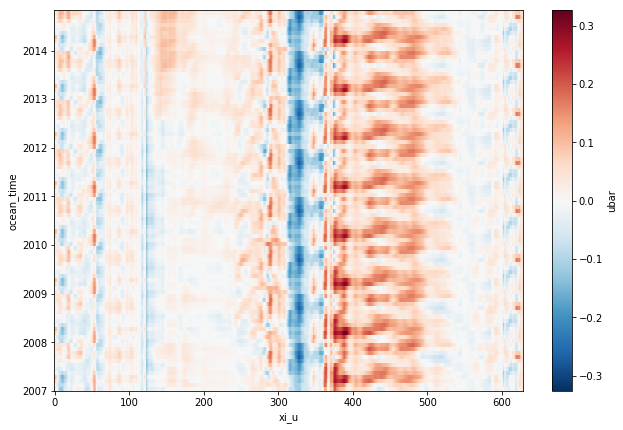

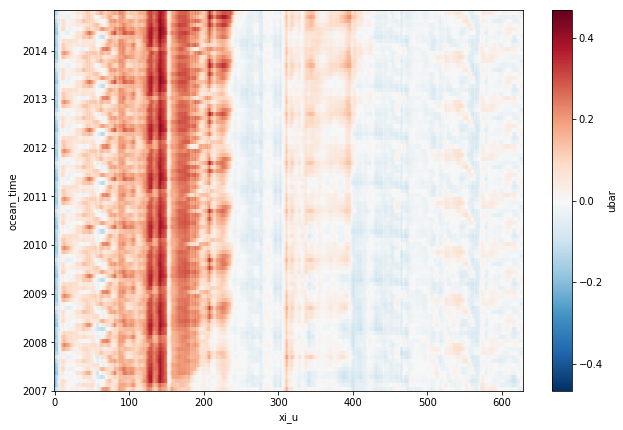

In [356]:
plt.close()
%matplotlib inline

avgn.isel(eta_u=529).ubar.plot(size=7)
#grd.h.plot.contour(colors='k',alpha=0.3)
plt.show()
avgn.isel(eta_u=0).ubar.plot(size=7)
#grd.h.plot.contour(colors='k',alpha=0.3)
plt.show()

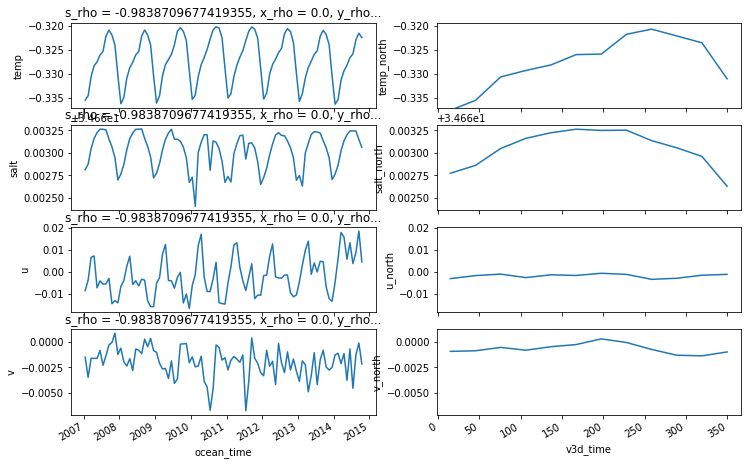

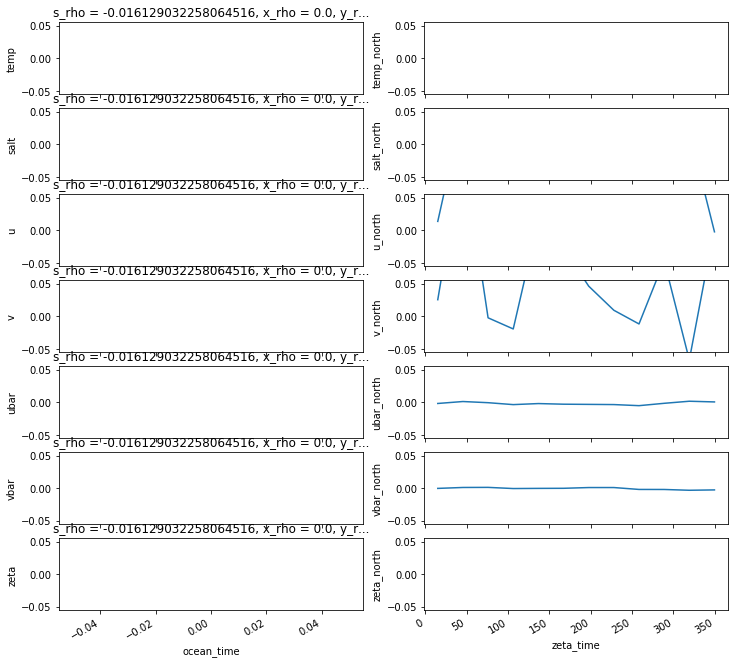

In [357]:
%matplotlib inline
bry_path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom10_bry.nc')
bry = xr.open_dataset(bry_path)
import pandas as pd

adj = avgn.sel(ocean_time=slice('1/1/2013','1/1/2037'),eta_rho=529,xi_rho=112,eta_u=529,xi_u=112,eta_v=528,xi_v=112).isel(s_rho=0)
br = bry.isel(xi_rho=112,xi_u=112).isel(s_rho=0)
plt.close()
fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(12,8))
for qunat,col in zip(['temp','salt','u','v'],range(4)):
    
    adj[qunat].plot(ax=axes[col,0])
    br[qunat+'_north'].plot(ax=axes[col,1])
    axes[col,1].set_ylim(axes[col,0].get_ylim())

plt.show()

adj = avgn.sel(ocean_time=slice('1/1/2029','1/1/2030'),eta_rho=529,xi_rho=112,eta_u=529,xi_u=112,eta_v=528,xi_v=112).isel(s_rho=30)
br = bry.isel(xi_rho=112,xi_u=112).isel(s_rho=30)
plt.close()
fig,axes = plt.subplots(nrows=7,ncols=2,figsize=(12,12))
for qunat,col in zip(['temp','salt','u','v','ubar','vbar','zeta'],range(7)):
    
    adj[qunat].plot(ax=axes[col,0])
    br[qunat+'_north'].plot(ax=axes[col,1])
    axes[col,1].set_ylim(axes[col,0].get_ylim())

plt.show()

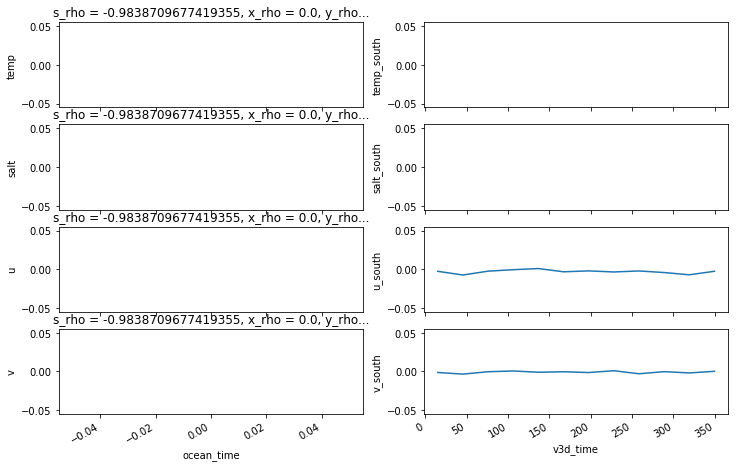

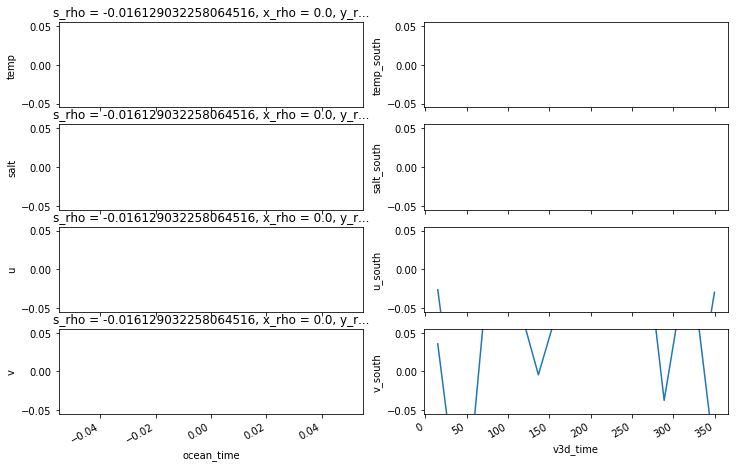

In [358]:
adj = avgn.sel(ocean_time=slice('1/1/2029','1/1/2031'),eta_rho=0,xi_rho=390,eta_u=0,xi_u=390,eta_v=0,xi_v=390).isel(s_rho=0)
br = bry.isel(xi_rho=390,xi_u=390).isel(s_rho=0)
plt.close()
fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(12,8))
for qunat,col in zip(['temp','salt','u','v'],range(5)):
    
    adj[qunat].plot(ax=axes[col,0])
    br[qunat+'_south'].plot(ax=axes[col,1])
    axes[col,1].set_ylim(axes[col,0].get_ylim())

plt.show()

adj = avgn.sel(ocean_time=slice('1/1/2029','1/1/2031'),eta_rho=0,xi_rho=390,eta_u=0,xi_u=390,eta_v=0,xi_v=390).isel(s_rho=30)
br = bry.isel(xi_rho=390,xi_u=390).isel(s_rho=30)
plt.close()
fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(12,8))
for qunat,col in zip(['temp','salt','u','v'],range(5)):
    
    adj[qunat].plot(ax=axes[col,0])
    br[qunat+'_south'].plot(ax=axes[col,1])
    axes[col,1].set_ylim(axes[col,0].get_ylim())

plt.show()

In [215]:
# %load src/features/make_roms_ds.py
#read in raw data as xr.dataset
import xarray as xr
import numpy as np


def make_4D_depth(grd,ds):
    
    depths = np.empty((ds.ocean_time.size,ds.s_rho.size,ds.eta_rho.size,ds.xi_rho.size))
    
    for tstep in log_progress(np.arange(ds.ocean_time.size),name='time'):

        h = grd.h.values
        zice = grd.zice.values
        theta_s = ds.theta_s.values[0]
        theta_b = ds.theta_b.values[0]
        hc = ds.hc.values[0]
        N = ds.s_rho.size
        zeta = ds.zeta[tstep].values
        Vstretching = ds.Vstretching.values[0]
        
        depths[tstep],s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)
        
    ds = ds.assign_coords(depth = xr.DataArray(depths,dims=['ocean_time','s_rho','eta_rho','xi_rho']))
    
    #ds['depth'] = ds.depth.where(ds.mask_rho == 1)
    
    return ds

In [258]:
#%%writefile src/features/roms_ds_tools.py
import xarray as xr
import numpy as np
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
from features.rotate_vector_roms import rotate_vector_roms
from features.calc_z import calc_z
from features.log_progress import log_progress
import gsw

def make_density(grd,ds):
    
    ds['rho'] = (('ocean_time','s_rho','eta_rho','xi_rho'),np.empty((ds.ocean_time.size,ds.s_rho.size,ds.eta_rho.size,ds.xi_rho.size)))
    for tstep in log_progress(np.arange(ds.ocean_time.size),name='time'):
        
        ds_sel = ds.isel(ocean_time=tstep)
        p = gsw.conversions.p_from_z(ds_sel.depth,grd.lat_rho)
        SA = gsw.conversions.SA_from_SP(ds_sel.salt,p,grd.lon_rho,grd.lat_rho)
        CT = gsw.conversions.CT_from_pt(SA,ds_sel.temp)
    
        ds['rho'][tstep]=gsw.density.rho(SA,CT,p)
    
    return ds


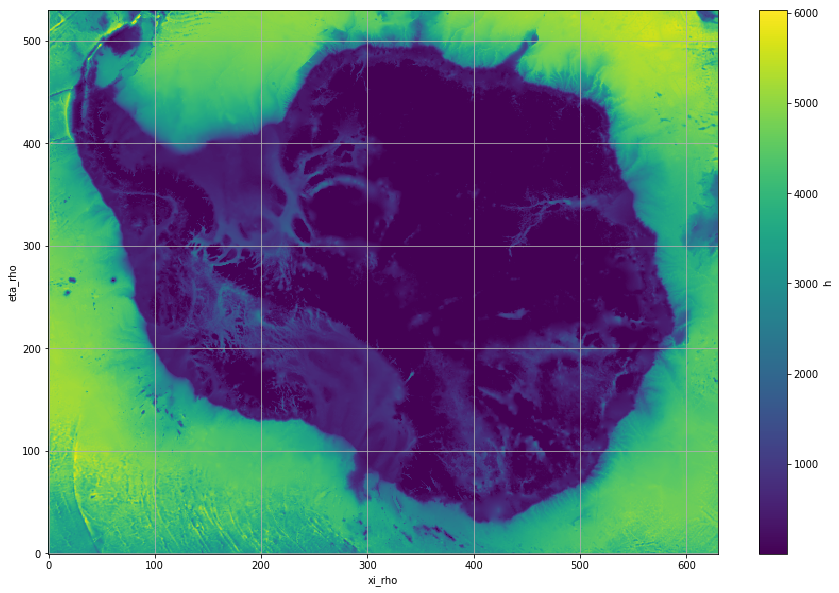

In [236]:
%matplotlib inline
plt.close()
grd.h.plot(size=10)
plt.grid('True')
plt.show()

In [359]:
avg_jump = avgn.sel(ocean_time=slice('1/1/2007','1/1/2047'))
avg_jump = make_4D_depth(grd,avg_jump)
avg_jump = make_density(grd,avg_jump)

VBox(children=(HTML(value=''), IntProgress(value=0, max=94)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=94)))

In [285]:
avg_jump = make_cartesian_grid_3D(grd,avg_jump)

MemoryError: 

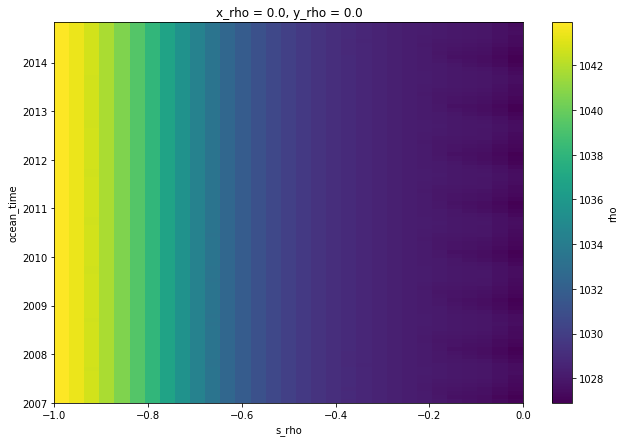

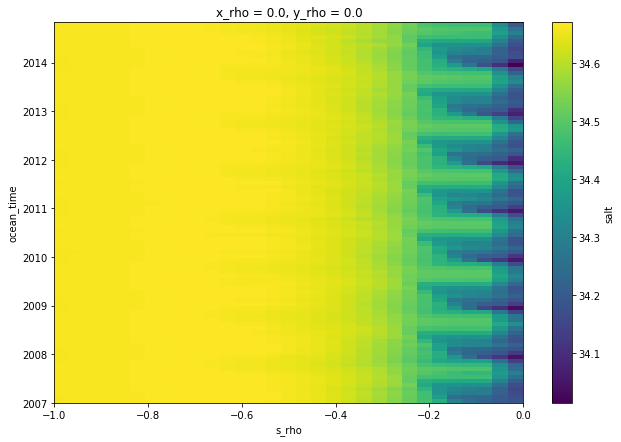

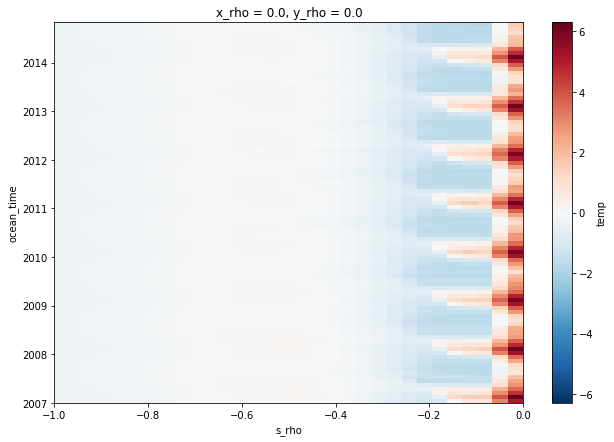

In [360]:
for var in ['rho','salt','temp']:
    avg_jump[var].isel(xi_rho=112,eta_rho=529).plot(size=7)
plt.show()

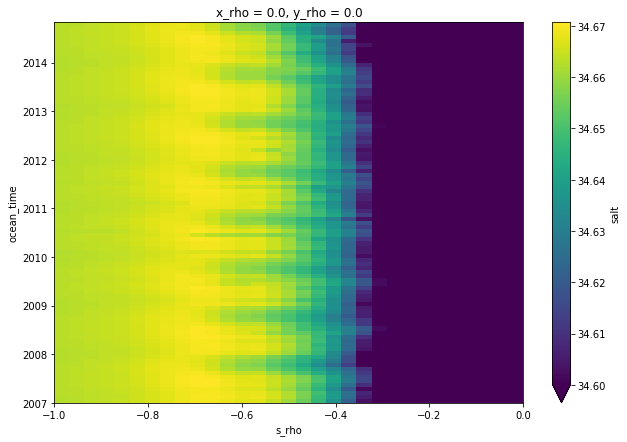

In [361]:
avg_jump['salt'].isel(xi_rho=112,eta_rho=529).plot(size=7,vmin=34.6)

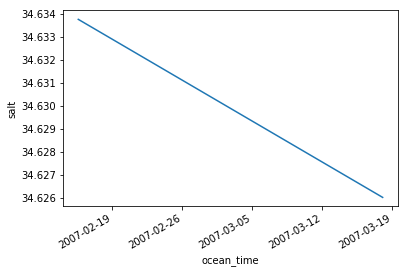

In [286]:
plt.close()
mask = (grd.lon_rho>-60) & (grd.lon_rho<20) & (grd.lat_rho<-60) & ((grd.h < 1000) | (ds.zice < 0.0)) & (avg_jump.depth < -500)
avg_jump.isel(ocean_time=[1,2]).where(mask).salt.mean(('s_rho','eta_rho','xi_rho')).plot()
plt.show()

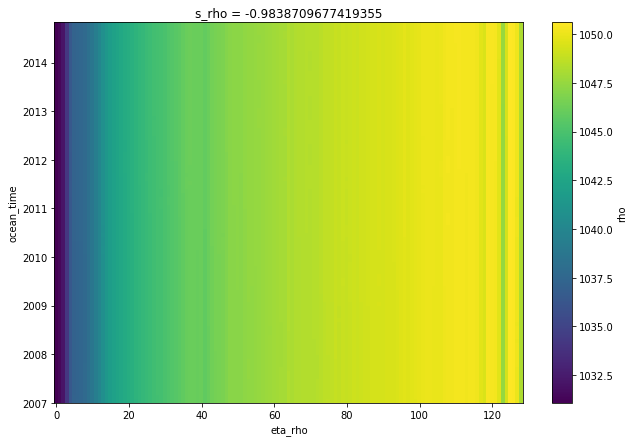

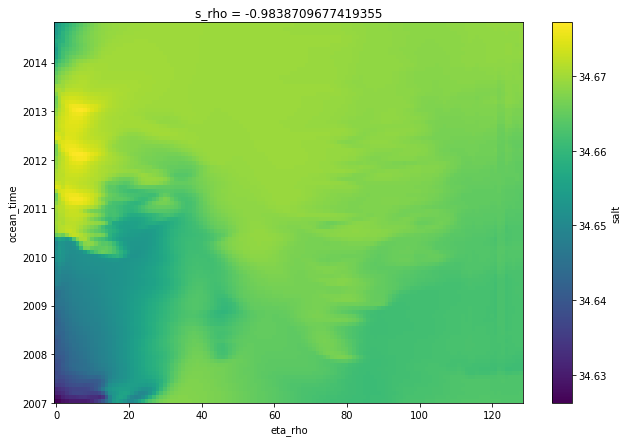

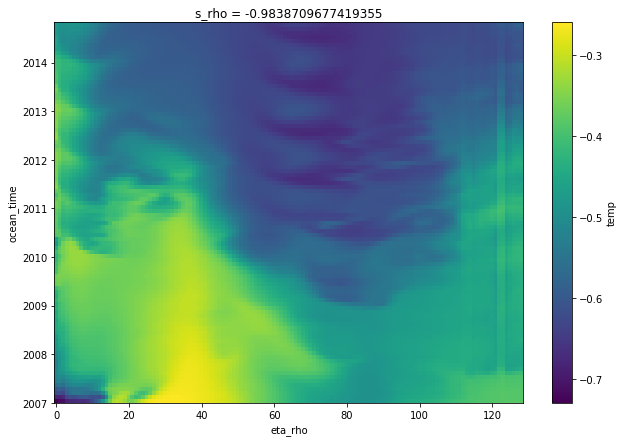

In [362]:
plt.close()
for var in ['rho','salt','temp']: 
    avg_jump[var].isel(xi_rho=150,eta_rho=slice(400,529),s_rho=0).plot(size=7)
    plt.show()

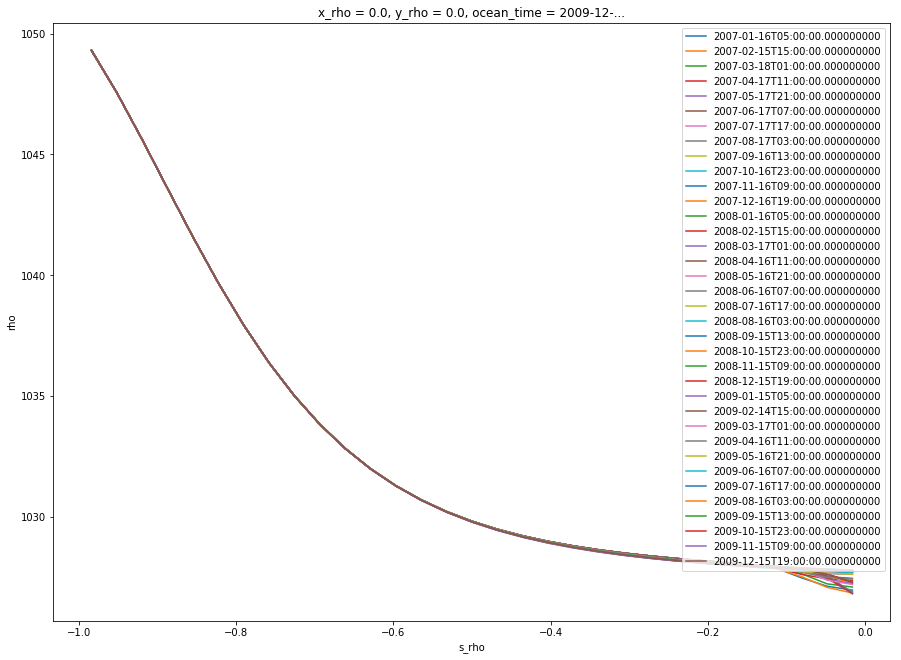

In [260]:
plt.figure(figsize=(15,11))
for t in range(avg_jump.ocean_time.size):
    
    avg_jump.rho.isel(eta_rho=500,xi_rho=150,ocean_time=t).plot(label=avg_jump.ocean_time[t].values)
plt.legend()
plt.show()

In [341]:
np.arange(0,angle.shape[1],bl).shape

(788,)

In [344]:
u[::bl,::bl].shape

(663, 788)

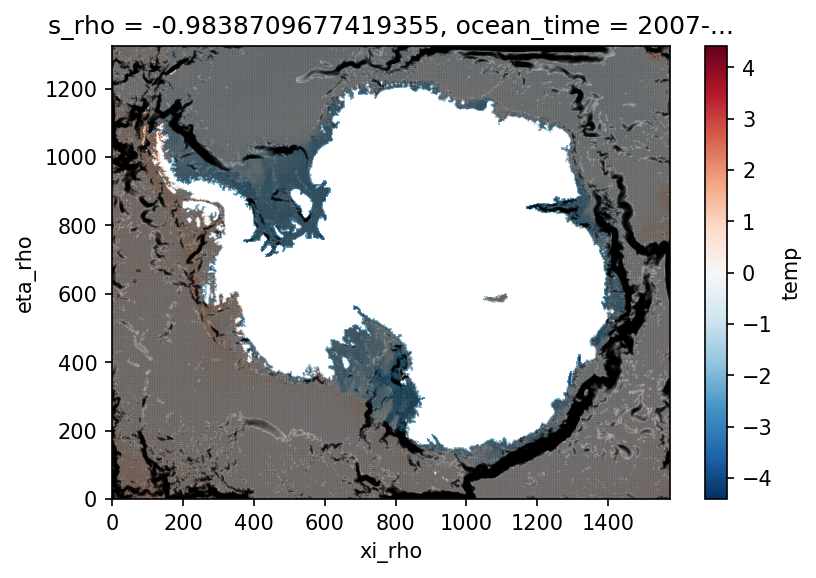

In [345]:
%matplotlib notebook
file_path = os.path.join(os.environ.get('rawdir'),'hre4_stable','ocean_avg_0001.nc')
grd_path = os.path.join(os.environ.get('rawdir'),'gdata','hr_exp','waom4_stable_grd.nc')

avg4 = xr.open_dataset(file_path,chunks={'xi_rho':200,'eta_rho':200})
grd4 = xr.open_dataset(grd_path)
angle = np.zeros_like(grd4.lon_rho.values)
u,v = rotate_vector_roms(avg4.u.isel(s_rho=0,ocean_time=-1).values, avg4.v.isel(s_rho=0,ocean_time=-1).values, angle)
oo = (grd4.mask_rho==1)
u[~oo]=np.nan
v[~oo]=np.nan

plt.close()
plt.figure(dpi=150)
avg4.temp[-1,0].plot()
plt.quiver(np.arange(0,angle.shape[1],bl),np.arange(0,angle.shape[0],bl),u[::bl,::bl],v[::bl,::bl],
                     pivot="mid", color='black',alpha=0.3,scale_units='xy',scale=0.01)
plt.show()

In [328]:
avg4.temp

<xarray.DataArray 'temp' (ocean_time: 3, s_rho: 31, eta_rho: 1325, xi_rho: 1575)>
dask.array<shape=(3, 31, 1325, 1575), dtype=float64, chunksize=(3, 31, 200, 200)>
Coordinates:
  * s_rho       (s_rho) float64 -0.9839 -0.9516 -0.9194 -0.8871 -0.8548 ...
    x_rho       (eta_rho, xi_rho) float64 dask.array<shape=(1325, 1575), chunksize=(200, 200)>
    y_rho       (eta_rho, xi_rho) float64 dask.array<shape=(1325, 1575), chunksize=(200, 200)>
  * ocean_time  (ocean_time) datetime64[ns] 2007-01-16T05:00:00 ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  time-averaged potential temperature
    units:      Celsius
    time:       ocean_time
    field:      temperature, scalar, series

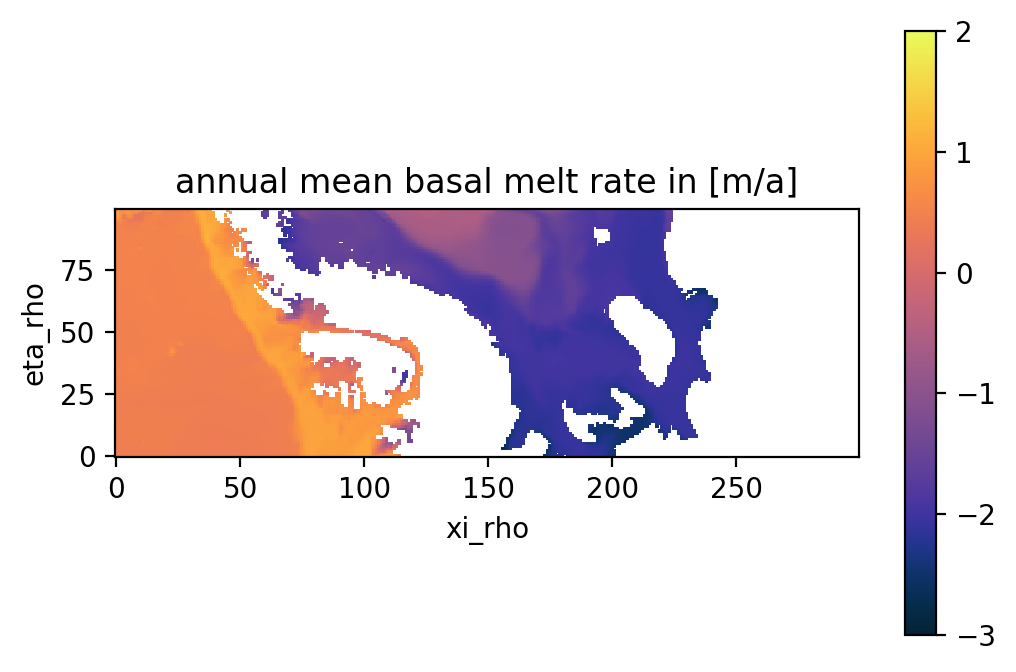

In [321]:
%matplotlib inline
import numpy as np
#prepare the quiver plot showing velocity arrows
angle = np.zeros_like(grd.lon_rho.values)
u_rho,v_rho = rotate_vector_roms(avgn.u.isel(s_rho=0,ocean_time=0).values, avgn.v.isel(s_rho=0,ocean_time=0).values, angle)
oo = (grd.mask_rho==1)
u_rho[~oo]=np.nan
v_rho[~oo]=np.nan
bl = 2
plt.close()
fig,ax0 = plt.subplots(dpi=200)
avgn.temp.where((grd.mask_rho==1)).isel(s_rho=0,ocean_time=0,eta_rho=slice(300,400),xi_rho=slice(0,300)).plot(cmap=cmo.thermal,ax=ax0,vmin=-3,vmax=2)
ax0.quiver(np.arange(0,300,bl),np.arange(300,400,bl),u_rho[300:400:bl,0:300:bl],v_rho[300:400:bl,0:300:bl],
                     pivot="mid", color='black',alpha=0.3,scale_units='xy',scale=0.01)
ax0.set_title('annual mean basal melt rate in [m/a]')
ax0.set_aspect('equal')
ax0.set_axis_off
plt.show()